# Прогноз заработной платы

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.
http://sophist.hse.ru/exes/tables/WAG_M.htm
Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.
Review criterialess 
Придерживайтесь стандартного алгоритма построения прогноза:

Визуальный анализ ряда
Стабилизация дисперсии (при необходимости)
Выбор порядка дифференцирования
Выбор начальных приближений для p,q,P,Q
Обучение и сравнение моделей-кандидатов, выбор победителя
Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.
Прогнозирование с помощью финальной модели.
Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


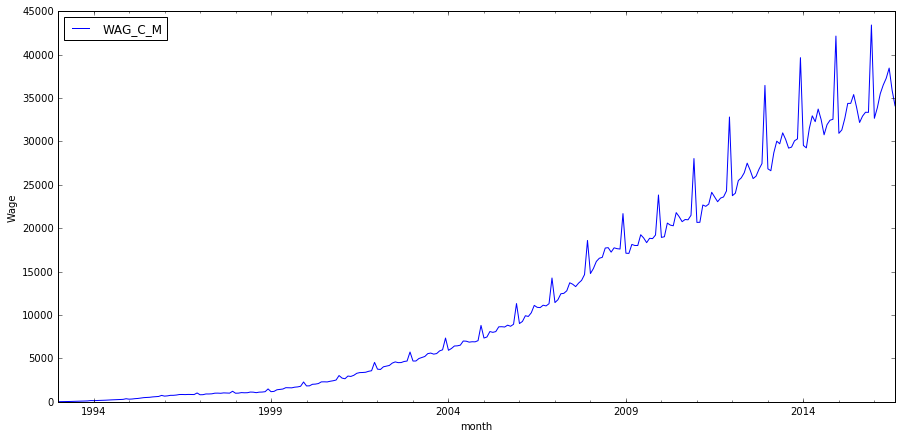

In [31]:
df = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], 
                   parse_dates=['month'], dayfirst=True)

plt.figure(figsize(15,7))
df.plot()
plt.ylabel('Wage')
pylab.show()

In [4]:
df.tail()

WAG_C_M
month              
2016-04-01  36497.0
2016-05-01  37270.0
2016-06-01  38447.0
2016-07-01  35888.0
2016-08-01  34095.0

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


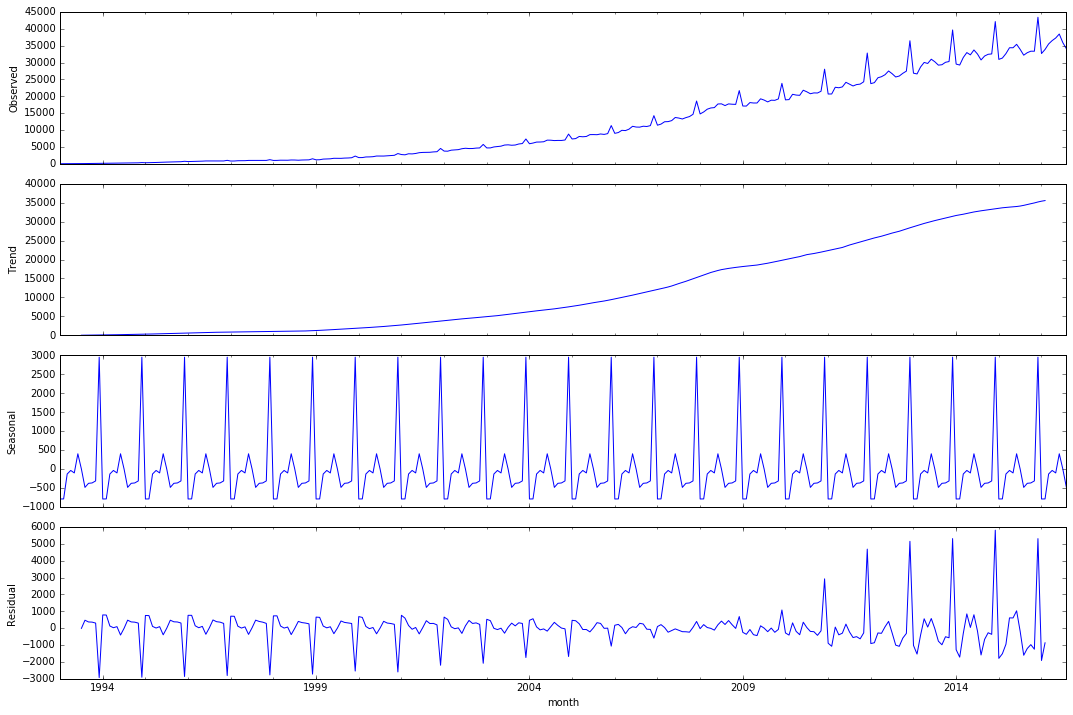

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

Вывод: критерий Дики-Фуллера не отвергает гипотезу нестационарности. Сделаем дальнейшие преобразования. 

В результате применения STL-декомпозиции — видим хорошо выраженный сезонный профиль и восходящий тренд. 
Это ещё раз нам подтверждает, что ряд нестационарный. 

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

В качестве следующего шага давайте сделаем стабилизацию дисперсии методом Бокса-Кокса. Это делает функция boxcox, она возвращает преобразованный ряд и автоматически каким-то образом наилучшее подобранное значение параметра лямбда ( λ). В данном случае это значение равно примерно 0,26. 

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


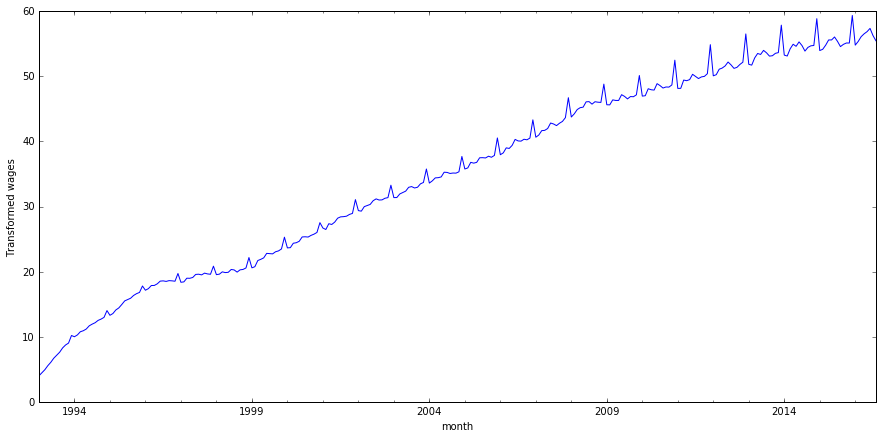

In [7]:
df['wage_box'], lmbda = stats.boxcox(df.WAG_C_M)
plt.figure(figsize(15,7))
df.wage_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wage_box)[1])

Критерий Дики-Фуллера на этом ряде даёт достигаемый уровень значимости примерно 0,7. То есть нулевая гипотеза нестационарности не отвергается, и этот ряд критерий Дики-Фуллера считает нестационарным. Мы очень хорошо видим тот самый восходящий тренд как и при STL-декомпозиции. 
Далее проведём дифференцирование ряда, для того чтобы добиться стационарности.

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


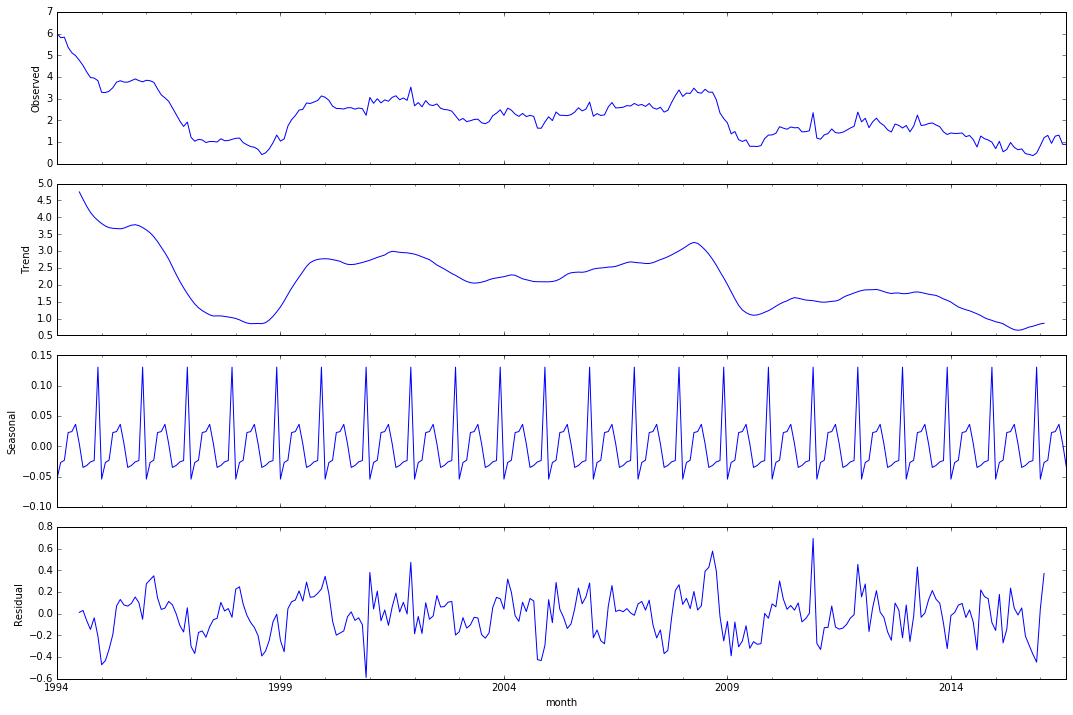

In [8]:
df['wage_box_diff'] = df.wage_box - df.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wage_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, достигаемый уровень значимости 0.015. Полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


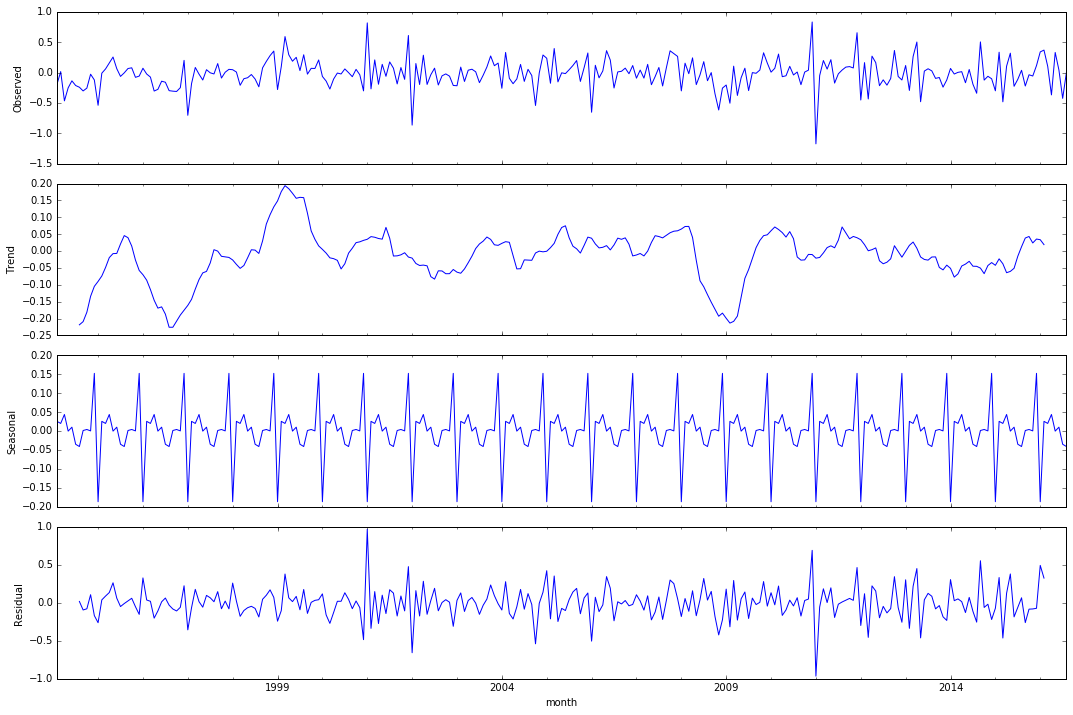

In [10]:
df['wage_box_diff2'] = df.wage_box_diff - df.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wage_box_diff2[13:])[1])

авайте применим ещё одно дифференцирование. На сей раз — обычное. На продифференцированном ещё раз ряде критерий Дики-Фуллера гипотезу нестационарности уверенно отвергает с очень маленьким достигаемым уровнем значимости. А вот так выглядит STL-декомпозиция два раза продифференцированного ряда. На этот раз мы на трендовой компоненте не видим никакого систематического поведения. То есть она колеблется примерно вокруг константы. Это то, чего мы хотели добиться. Видимо, этот ряд уже можно считать стационарным. Перейдём теперь к подбору моделей ARIMA. 

Гипотеза нестационарности отвергается на уровне значимости 0,  и визуально ряд выглядит лучше, на трендевой компоненте не видим никого систематического поведения.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

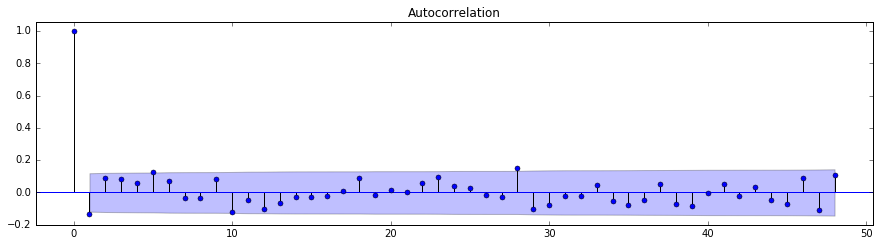

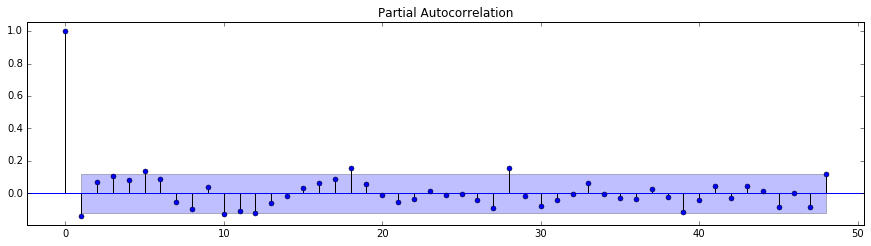

In [11]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Посмотрим на автокорреляционную и частично автокорреляционную функцию вот этого два раза продифференцированного ряда. На верхнем графике — автокорреляционная функция, и по этому графику мы будем подбирать начальное приближение для параметров q и Q. 
Начальным приближением для Q мы будем брать 0. На верхнем графике автокорреляционной функции значимо отличаются от нуля пятый несезонный лаг. Таким образом, для q начальное приближение мы будем брать равным 5. 
На частично автокорреляционной функции единственный сезонный лаг, значимо отличающийся от нуля — это лаг 5. 
P возьмём равным 0, для начала. 
Возьмём, p равным 5, так как на частично автокорреляционной функции единственно значимо отличающийся от нуля сезонный лаг -5.

Начальные приближения: Q=1, q=5, P=1, p=5

In [13]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 1)
D=1
Qs = range(0, 1)

In [14]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

Давайте просто настроим все их и посчитаем для каждой значение информационного критерия Акаике, выберем ту модель, у которой это значение будет минимальным. Это делает следующий кусок кода.

In [17]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.wage_box, order=(param[0], d, param[1]), 
                                seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 4, 0, 0)
CPU times: user 15.2 s, sys: 142 ms, total: 15.4 s
Wall time: 10.4 s


In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
25  (5, 5, 0, 0) -22.879525
18  (3, 5, 0, 0) -15.193425
9   (1, 5, 0, 0) -13.661214
22  (4, 5, 0, 0) -13.623635
13  (2, 5, 0, 0) -12.015789


Перед тем как делать перебор, давайте отключим Warning'и. Дело в том, что не все модели, которые мы будем перебирать, можно хорошо настроить. Часть из них будут расходящимися, и про все такие модели Python нам будет выдавать предупреждение о том, что сходимости не произошло. Отключим вывод этих предупреждений и будем просто печатать параметры каждой модели, которая не сошлась. Прекрасно. Этот код выполняется довольно долго. 60 моделей перебирается в течение примерно 20 секунд. Вот есть несколько комбинаций значений параметров, при которых сходимости не произошло. Давайте посмотрим на лучшие модели. Самый лучший результат, то есть результат с минимальным значением информационного критерия Акаике показала вот такая модель: С p = 2, q = 1, P = 0 и Q = 1. Если мы посмотрим на всякий случай на несколько следующих по AIC'у моделей, мы увидим, что эти модели хоть и близки по значению информационного критерия, но параметров в них больше. Таким образом, мы действительно можем убедиться в том, что наша лучшая модель с самым маленьким Акаике не станет немножко незначительно хуже, если мы её чуть-чуть упростим. То есть никакая простая модель, более простая модель здесь в топ не входит. Модель на пятом месте — достаточно простая. Параметров в ней на один меньше, но значение информационного критерия Акаике у неё уже больше на три единицы

Лучшая модель:

In [19]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(0, 1, 0, 12)   Log Likelihood                  22.440
Date:                            Sun, 16 Apr 2017   AIC                            -22.880
Time:                                    12:16:12   BIC                             17.259
Sample:                                01-01-1993   HQIC                            -6.787
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0479      6.163      0.008      0.994     -12.031      12.127
ar.L2          0.0116      4.285   

 Давайте посмотрим на нашу лучшую модель. Используем метод Summary и посмотрим, что наша функция из statsmodels нам настроила. Мы получили модель SARIMAX с параметрами (2, 1, 1) (0, 1, 1). Сезонный период мы фиксировали и задали равным 12. Что ещё здесь есть полезного в этом выводе? Здесь есть значение статистики критерия Льюнг — Бокса при каком-то автоматически выбранном Q и соответствующий достигаемый уровень значимости — мы видим, что достигаемый уровень значимости достаточно большой. То есть, по всей видимости, остатки модели не автокоррелированы. Вот всё, что в этом блоке выводится, вся информация, она касается именно остатков. Ну что здесь ещё можно посмотреть интересного? Пожалуй, всё остальное не представляет большого интереса

Её остатки:

Критерий Стьюдента: p=0.255351
Критерий Дики-Фуллера: p=0.000000


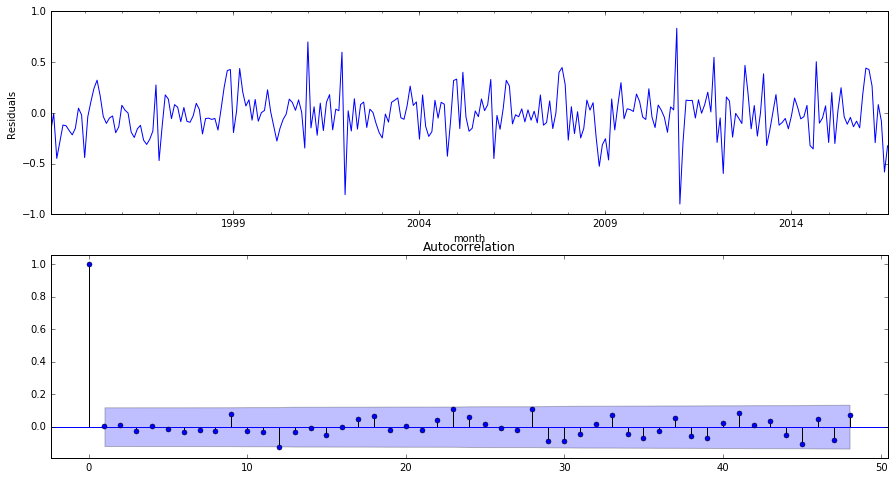

In [20]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

На первый взгляд кажется, что всё в порядке. В этих остатках не видно никакого тренда, никакой сезонности, они довольно-таки похожи на шум. Вот так выглядит автокорреляционная функция этих остатков, и мы видим, что здесь нет никакой существенной структуры. Да? Некоторые лаги действительно значимо отличаются от нуля. Но эти лаги находятся достаточно далеко, то есть эти лаги — большие. Ну, естественно, что какие-то лаги, когда вы строите автокорреляционную функцию, могут отличаться от нуля чисто случайно, просто в силу эффекта множественной проверки гипотез. Поэтому об этом можно не беспокоиться. Тем более вот здесь отличие от нуля возникает при лаге 22 — это лаг не сезонный, следовательно, можно закрыть на это глаза. 

Проверим свойства остатков с помощью формальных критериев. Критерий Стьюдента проверяет гипотезу несмещённости и её не отвергает с достигаемым уровнем значимости примерно 0,26. Критерий Дики-Фуллера уверенно отвергает гипотезу нестационарности. Таким образом, мы получаем, что остатки не смещены, стационарны и неавтокоррелированы. Следовательно, наша модель достаточно хороша.

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

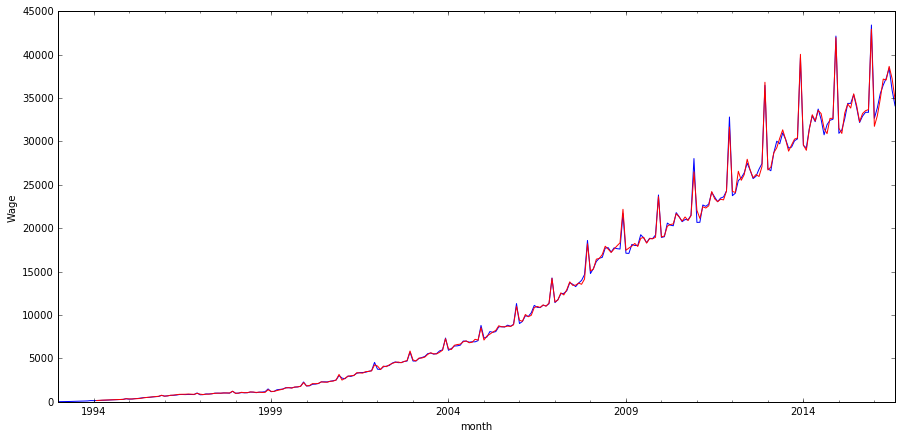

In [41]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()

In [85]:
df_update=pd.read_csv('wage_update.csv',';', index_col=['month'],parse_dates=['month'], dayfirst=True)


In [86]:
df_update.tail()

wages
month            
2016-10-01  35749
2016-11-01  36195
2016-12-01  47554
2017-01-01  35369
2017-02-01  35900

### Прогноз

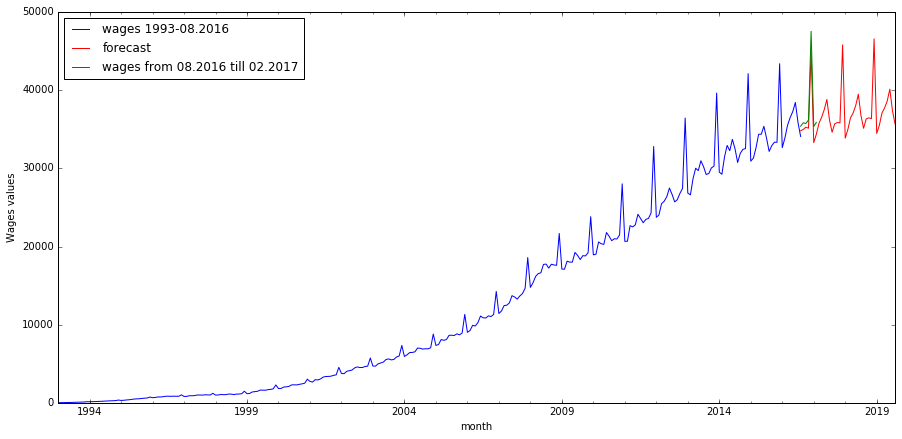

In [94]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) 
             for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=283, end=350), lmbda)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot(label='wages 1993-08.2016')
df2.forecast.plot(color='r')
plt.ylabel('Wages values')

df_update.wages.plot(color='g',label='wages from 08.2016 till 02.2017')

plt.legend(loc=2)
pylab.show()



Давайте посмотрим, насколько хорошо эта модель описывает данные. 

Вывод:На графике синяя линия — это исходный ряд с данными до 08.2016. Красным обозначено то, что предсказывает нашу модель в этом месте.Прогноз делается с помощью функции predict. Не забудем применить обратное преобразование к преобразованию Бокса-Кокса, потому что модель, которую мы подобрали, она не знает о том, что исходный ряд был преобразован.  Мы видим, что действительно модель и данные достаточно похожи друг на друга. 
Зеленым обозначен ряд с данными с 08.2016 до 02.2017. Данные достаточно похожи на прогноз, произведеный на основании данных до этого периода. Еще раз доказывает, что прогноз выглядет достаточно адекватным.
 